# Excitation-Inhibition balance on the artificial matrix

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '95c0ca0cdca3f00e55f0e46dd9a8b8c1f492d94e'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from analysis_functions import calculate_recall_success_sequences
from connectivity_functions import create_artificial_manager
from plotting_functions import plot_weight_matrix
from analysis_functions import calculate_excitation_inhibition_ratio, get_excitation, get_inhibition

## Example

In [4]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 20

dt = 0.001
n = 10


beta = False
value = 1
inhibition = -1.0
extension = 1
decay_factor = 0.3
sequence_decay = 0.0


tau_z_pre = 0.150
g_w = 1.0
g_w_ampa = 1.0
g_a = 97.0

sequences = [[i for i in range(n_patterns)]]


manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)

manager.nn.tau_z_pre = tau_z_pre
manager.nn.g_w = g_w
manager.nn.g_w_ampa = g_w_ampa
manager.nn.g_a = g_a

w = manager.nn.w
ratio, var, ratios = calculate_excitation_inhibition_ratio(manager.nn, sequences)

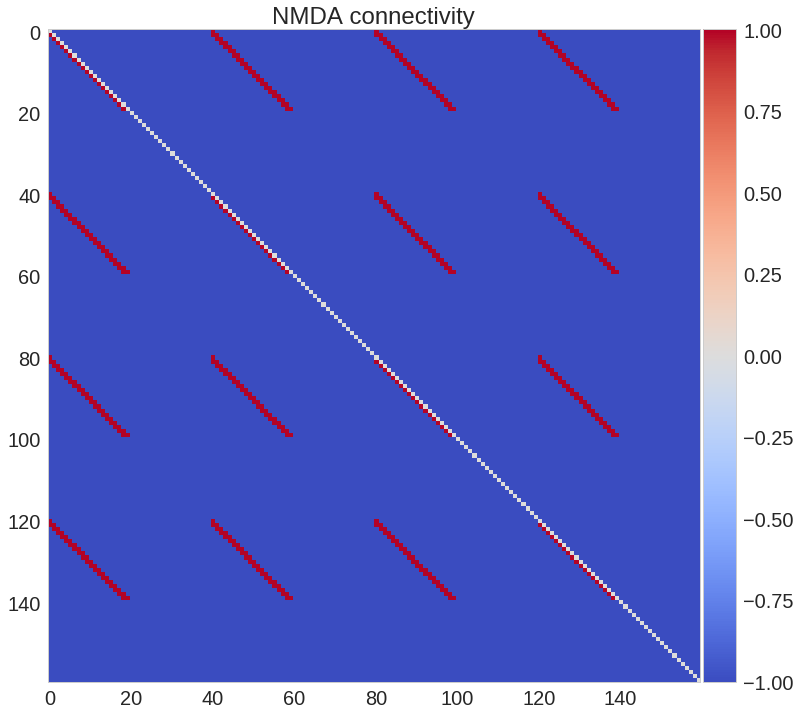

In [5]:
plot_weight_matrix(manager.nn, one_hypercolum=False)

In [6]:
def excitation_artificial_matrix(index, value, hypercolumns):
    if index==0:
        return value * (hypercolumns - 1)
    else:
        return value * hypercolumns + value * (hypercolumns - 1)
    
def inhibition_artificial_matrix(index, inhibition, hypercolumns, minicolumns):
    if index==0:
        return inhibition * hypercolumns * (minicolumns - 1)
    else:
        return inhibition * hypercolumns * (minicolumns - 2)

In [7]:
index = 1
exc = get_excitation(index, manager.nn.w)
exc_theo = excitation_artificial_matrix(index, value, hypercolumns)
print('total excitation', np.sum(exc))
print('theroetical excitation', exc_theo)

('total excitation', 7.0)
('theroetical excitation', 7)


In [8]:
index = 1
inh = get_inhibition(index, manager.nn.w)
inh_theo = inhibition_artificial_matrix(index, inhibition, hypercolumns, minicolumns)
print('total inhibition', np.sum(inh))
print('theoretical inhibition', inh_theo)

('total inhibition', -152.0)
('theoretical inhibition', -152.0)


Except for the first element where the inter-sequence nmda conntribution is not present

In [9]:
index = 0
exc = get_excitation(index, manager.nn.w)
exc_theo = excitation_artificial_matrix(index, value, hypercolumns)
inh = get_inhibition(index, manager.nn.w)
inh_theo = inhibition_artificial_matrix(index, inhibition, hypercolumns, minicolumns)

print('total excitation', np.sum(exc))
print('theoretical excitation', exc_theo)

print('total inhibition', np.sum(inh))
print('theoretical inhibition', inh_theo)

('total excitation', 3.0)
('theoretical excitation', 3)
('total inhibition', -156.0)
('theoretical inhibition', -156.0)


Let's build a function for calculating the ratio

In [10]:
def calculate_excitation_inhibition_ratio_artificial(value, inhibition, hypercolumns, minicolumns, n_patterns):
    
    excitation_normal = value * hypercolumns + value * (hypercolumns - 1)
    inhibition_normal = -1 * inhibition * hypercolumns * (minicolumns - 2)
    normal = ((n_patterns - 1.0) / n_patterns) * (excitation_normal / inhibition_normal)
    
    excitation_first = value * (hypercolumns - 1)
    inhibition_first = -1 * inhibition * hypercolumns * (minicolumns - 1)
    first = (1.0 / n_patterns) * (excitation_first / inhibition_first)
    
    return normal + first

In [11]:
ratio, var, ratios = calculate_excitation_inhibition_ratio(manager.nn, sequences)
ratio_theo = calculate_excitation_inhibition_ratio_artificial(value, inhibition,
                                                              hypercolumns, minicolumns, n_patterns)

print('ratio', ratio)
print('ratio theoretical', ratio_theo)

('ratio', 0.044711538461538455)
('ratio theoretical', 0.044711538461538455)


## Ratio dependence on excitation

In [12]:
values = np.arange(0.1, 10, 0.1)
inhibitions = [-3, -1, -0.5]
ratios = []

for inhibition in inhibitions:
    ratio_theo = calculate_excitation_inhibition_ratio_artificial(values, inhibition, hypercolumns, 
                                                                  minicolumns, n_patterns)
    
    ratios.append(ratio_theo)

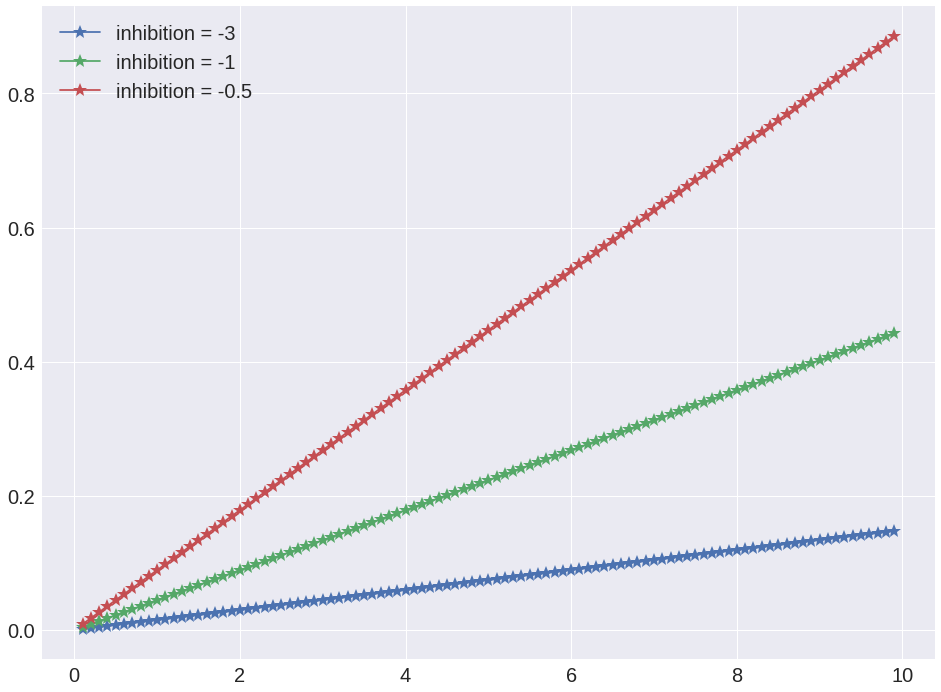

In [13]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for ratio, inhibition in zip(ratios, inhibitions):
    ax.plot(values, ratio, '*-', markersize=14, label='inhibition = ' + str(inhibition))
    
ax.legend();

#### Extension

In [14]:
beta = False
value = 1
inhibition = -0.1
extension = 1
decay_factor = 0.3
sequence_decay = 0.0

values = np.arange(0.1, 1, 0.1)
extensions = [1, 2, 4, 7, 10]

ratios_list = []
for extension in extensions:
    ratios = []
    for value in values:
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                        extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                        dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratios.append(ratio)
    ratios_list.append(ratios)

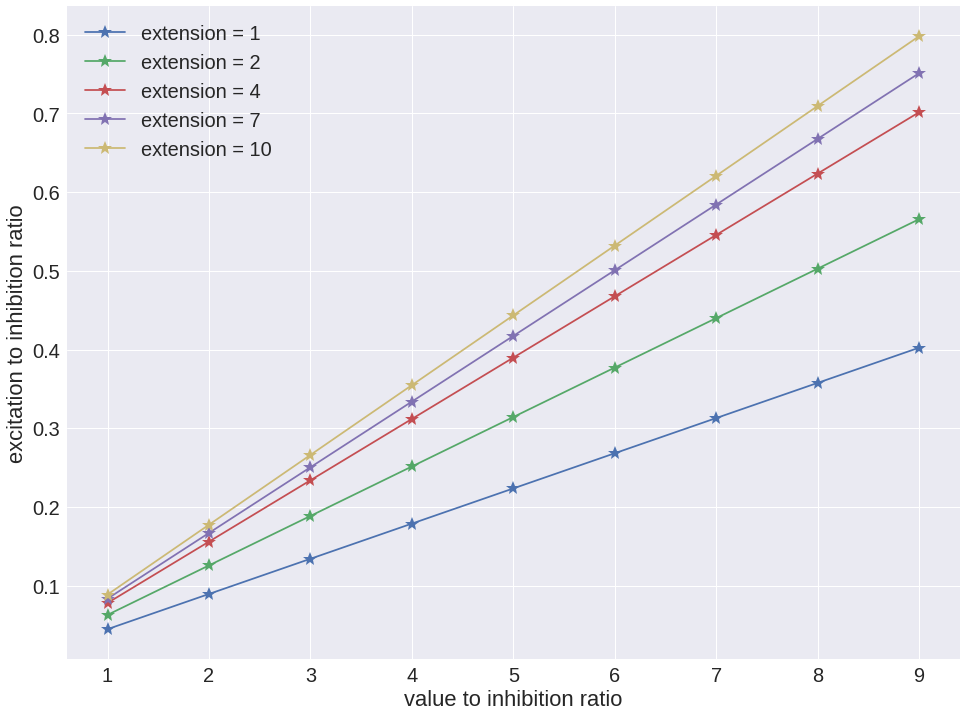

In [15]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

value_to_inhibition = [value / -inhibition for value in values]

for ratios, ext in zip(ratios_list, extensions):
    ax.plot(value_to_inhibition, ratios, '*-', markersize=14, label='extension = ' + str(ext))

    
ax.set_xlabel('value to inhibition ratio')
ax.set_ylabel('excitation to inhibition ratio')
ax.legend();

#### Decay factor

In [16]:
beta = False
value = 1
inhibition = -0.1
extension = 5
decay_factor = 0.3
sequence_decay = 0.0

values = np.arange(0.1, 1, 0.1)
decay_factors = [0.0, 0.1, 0.3, .6, 0.9]

ratios_list = []
for decay_factor in decay_factors:
    ratios = []
    for value in values:
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                        extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                        dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratios.append(ratio)
    ratios_list.append(ratios)

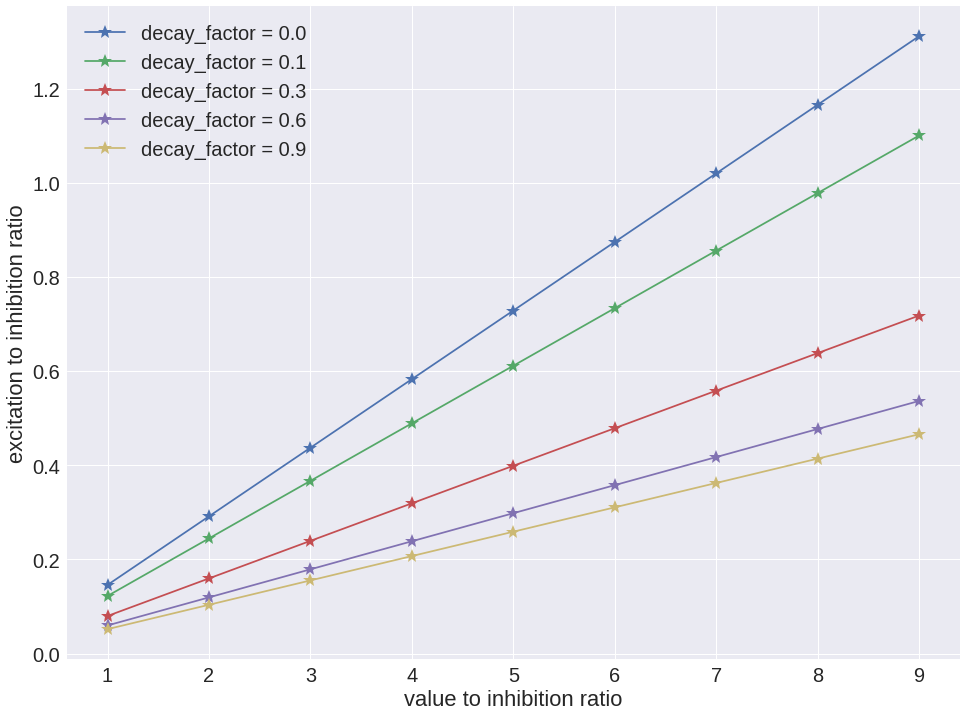

In [17]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

value_to_inhibition = [value / -inhibition for value in values]

for ratios, decay_factor in zip(ratios_list, decay_factors):
    ax.plot(value_to_inhibition, ratios, '*-', markersize=14, label='decay_factor = ' + str(decay_factor))

    
ax.set_xlabel('value to inhibition ratio')
ax.set_ylabel('excitation to inhibition ratio')
ax.legend();

#### Sequence decay

In [18]:
beta = False
value = 1
inhibition = -0.1
extension = 1
decay_factor = 0.3
sequence_decay = 0.0

values = np.arange(0.1, 1, 0.1)
sequence_decays = [0.0, 0.1, 0.3, .6, 0.9]

ratios_list = []
for sequence_decay in sequence_decays:
    ratios = []
    for value in values:
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                        extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                        dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratios.append(ratio)
    ratios_list.append(ratios)

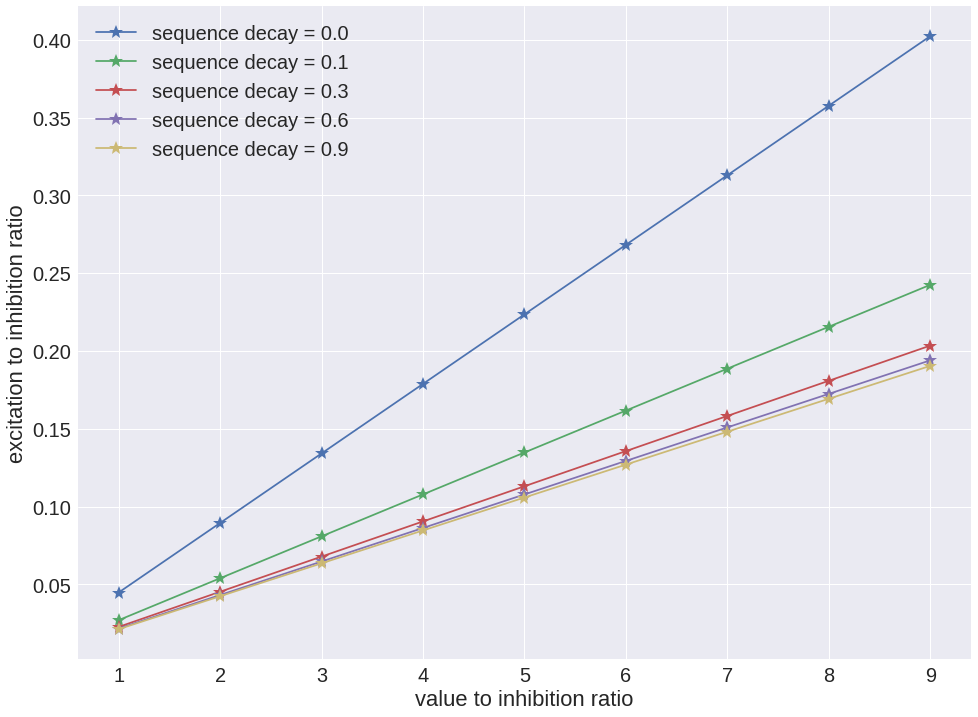

In [19]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

value_to_inhibition = [value / -inhibition for value in values]

for ratios, sequence_decay in zip(ratios_list, sequence_decays):
    ax.plot(value_to_inhibition, ratios, '*-', markersize=14, label='sequence decay = ' + str(sequence_decay))

    
ax.set_xlabel('value to inhibition ratio')
ax.set_ylabel('excitation to inhibition ratio')
ax.legend();

#### Minicolumns variation

In [76]:
hypercolumns = 4
minicolumns = 30
n_patterns = 5
sequences = [[i for i in range(n_patterns)]]

beta = False
value = 1
inhibition = -0.1
extension = 1
decay_factor = 0.5
sequence_decay = 0.0

values = np.arange(0.1, 1.1, 0.1)
minicolumns_range = np.arange(10, 65, 5)
ratio_matrix = np.zeros((values.size, inhibitions.size))
ratio_matrix_ampa =  np.zeros((values.size, inhibitions.size))

for value_index, value in enumerate(values):
    for minicolumns_index, minicolumns in enumerate(minicolumns_range):
        
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                    extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratio_matrix[value_index, minicolumns_index] = ratio
        
        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=True)
        ratio_matrix_ampa[value_index, minicolumns_index] = ratio

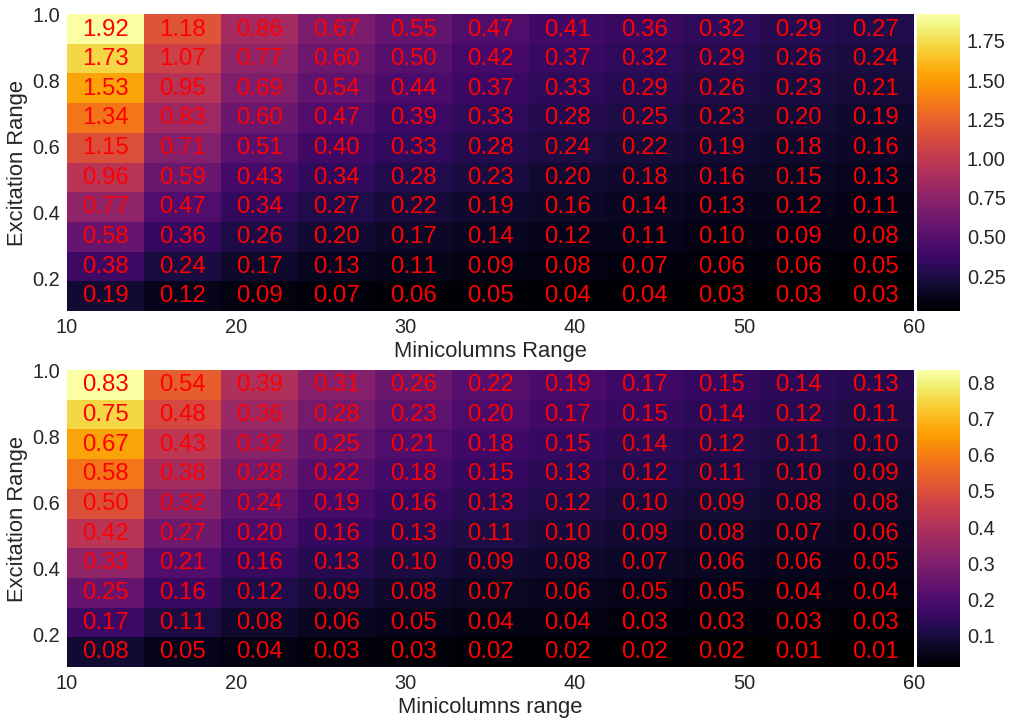

In [77]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

cmap = 'inferno'
text = True

extent = [minicolumns_range[0], minicolumns_range[-1], values[0], values[-1]]

size_x = minicolumns_range.size
size_y = values.size


im1 = ax1.imshow(ratio_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Minicolumns Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

im2 = ax2.imshow(ratio_matrix_ampa, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')

ax2.set_xlabel('Minicolumns range')
ax2.set_ylabel('Excitation Range')

ax2.grid()

# Add the text
x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

if text:
    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label1 = ratio_matrix[y_index, x_index]
            label2 = ratio_matrix_ampa[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            label1 = "{:4.2f}".format(label1)
            label2 = "{:4.2f}".format(label2)
            ax1.text(text_x, text_y, label1, color='red', ha='center', va='center')
            ax2.text(text_x, text_y, label2, color='red', ha='center', va='center')


            
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');            

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical');            

#### n_patterns

In [92]:
hypercolumns = 4
minicolumns = 30
n_patterns = 5


beta = False
value = 1
inhibition = -0.1
extension = 1
decay_factor = 0.5
sequence_decay = 0.0

values = np.arange(0.1, 1.1, 0.1)
n_patterns_range = np.arange(3, 33, 3)
ratio_matrix = np.zeros((values.size, n_patterns_range.size))
ratio_matrix_ampa =  np.zeros((values.size, n_patterns_range.size))

for value_index, value in enumerate(values):
    for n_patterns_index, n_patterns in enumerate(n_patterns_range):
        sequences = [[i for i in range(n_patterns)]]
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                    extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratio_matrix[value_index, n_patterns_index] = ratio
        
        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=True)
        ratio_matrix_ampa[value_index, n_patterns_index] = ratio

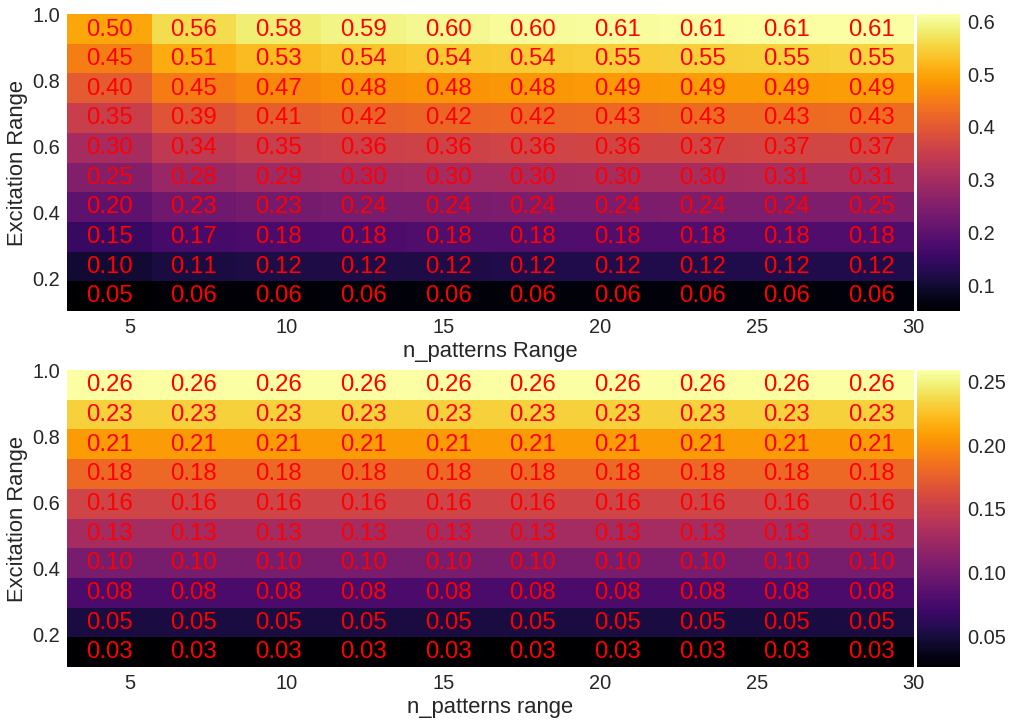

In [93]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

cmap = 'inferno'
text = True

extent = [n_patterns_range[0], n_patterns_range[-1], values[0], values[-1]]

size_x = n_patterns_range.size
size_y = values.size


im1 = ax1.imshow(ratio_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('n_patterns Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

im2 = ax2.imshow(ratio_matrix_ampa, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')

ax2.set_xlabel('n_patterns range')
ax2.set_ylabel('Excitation Range')

ax2.grid()

# Add the text
x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

if text:
    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label1 = ratio_matrix[y_index, x_index]
            label2 = ratio_matrix_ampa[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            label1 = "{:4.2f}".format(label1)
            label2 = "{:4.2f}".format(label2)
            ax1.text(text_x, text_y, label1, color='red', ha='center', va='center')
            ax2.text(text_x, text_y, label2, color='red', ha='center', va='center')


            
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');            

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical');   

#### hypercolumns

In [90]:
hypercolumns = 4
minicolumns = 30
n_patterns = 5
sequences = [[i for i in range(n_patterns)]]

beta = False
value = 1
inhibition = -0.1
extension = 1
decay_factor = 0.5
sequence_decay = 0.0

values = np.arange(0.1, 1.1, 0.1)
hypercolumns_range = np.arange(3, 33, 3)
ratio_matrix = np.zeros((values.size, hypercolumns_range.size))
ratio_matrix_ampa =  np.zeros((values.size, hypercolumns_range.size))

for value_index, value in enumerate(values):
    for hypercolumns_index, hypercolumns in enumerate(hypercolumns_range):
        
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                    extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratio_matrix[value_index, hypercolumns_index] = ratio
        
        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=True)
        ratio_matrix_ampa[value_index, hypercolumns_index] = ratio

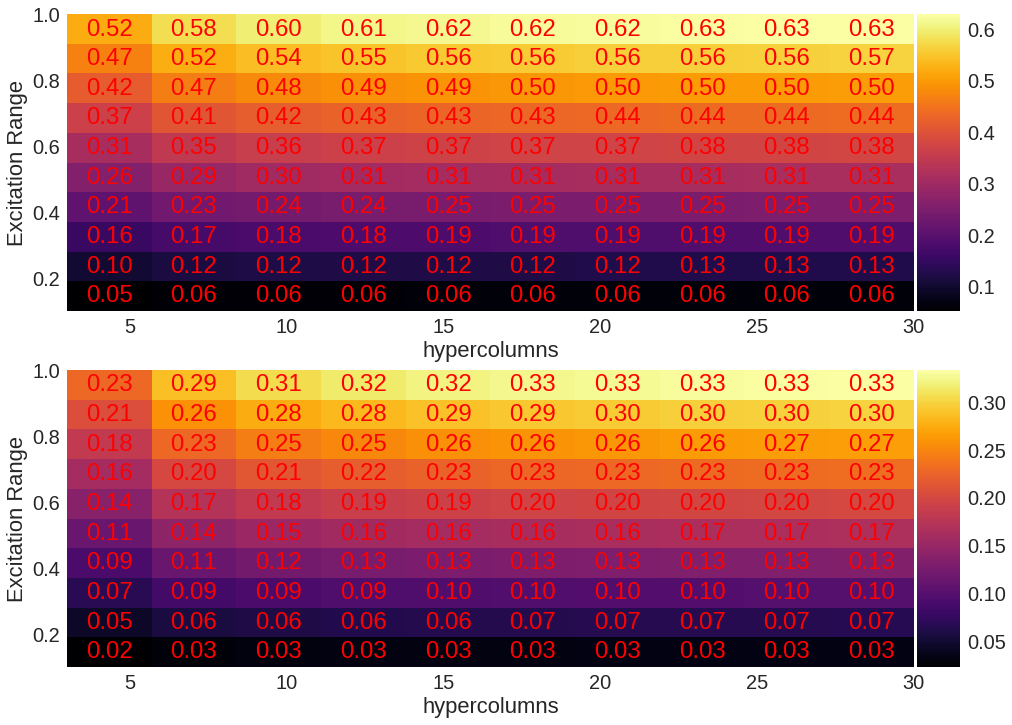

In [91]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

cmap = 'inferno'
text = True

extent = [hypercolumns_range[0], hypercolumns_range[-1], values[0], values[-1]]
size_x = hypercolumns_range.size
size_y = values.size

im1 = ax1.imshow(ratio_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')

ax1.set_xlabel('hypercolumns')
ax1.set_ylabel('Excitation Range')

ax1.grid()

im2 = ax2.imshow(ratio_matrix_ampa, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')

ax2.set_xlabel('hypercolumns')
ax2.set_ylabel('Excitation Range')

ax2.grid()

# Add the text
x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

if text:
    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label1 = ratio_matrix[y_index, x_index]
            label2 = ratio_matrix_ampa[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            label1 = "{:4.2f}".format(label1)
            label2 = "{:4.2f}".format(label2)
            ax1.text(text_x, text_y, label1, color='red', ha='center', va='center')
            ax2.text(text_x, text_y, label2, color='red', ha='center', va='center')


            
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');            

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical');    

#### Value to inhibition color plot

In [94]:
hypercolumns = 4
minicolumns = 30
n_patterns = 10
sequences = [[i for i in range(n_patterns)]]

beta = False
value = 1
inhibition = -0.1
extension = 1
decay_factor = 0.5
sequence_decay = 0.0

values = np.arange(0.1, 1, 0.1)
inhibitions = np.arange(0.1, 1, 0.1)
ratio_matrix = np.zeros((values.size, inhibitions.size))
ratio_matrix_ampa =  np.zeros((values.size, inhibitions.size))

for value_index, value in enumerate(values):
    for inhibition_index, inhibition in enumerate(inhibitions):
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=-inhibition,
                                    extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratio_matrix[value_index, inhibition_index] = ratio
        
        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=True)
        ratio_matrix_ampa[value_index, inhibition_index] = ratio

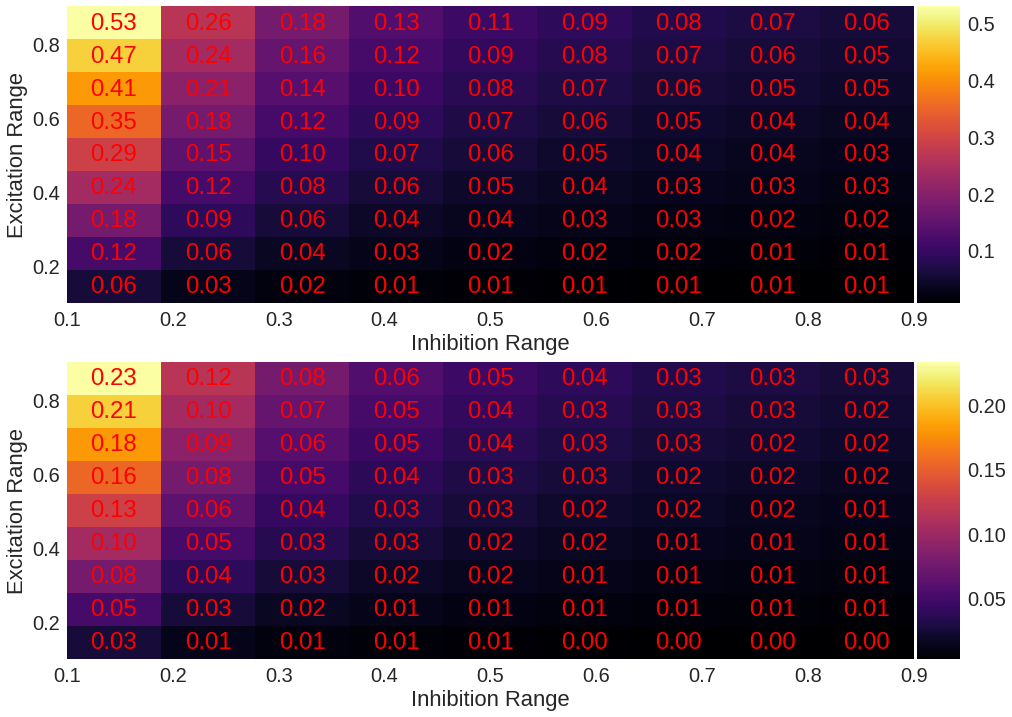

In [95]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

cmap = 'inferno'
text = True

extent = [inhibitions[0], inhibitions[-1], values[0], values[-1]]
im1 = ax1.imshow(ratio_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

im2 = ax2.imshow(ratio_matrix_ampa, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')

ax2.set_xlabel('Inhibition Range')
ax2.set_ylabel('Excitation Range')

ax2.grid()

# Add the text
x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibitions.size
size_y = values.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

if text:
    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label1 = ratio_matrix[y_index, x_index]
            label2 = ratio_matrix_ampa[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            label1 = "{:4.2f}".format(label1)
            label2 = "{:4.2f}".format(label2)
            ax1.text(text_x, text_y, label1, color='red', ha='center', va='center')
            ax2.text(text_x, text_y, label2, color='red', ha='center', va='center')


            
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');            

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical');            

In [100]:
from analysis_functions import calculate_excitation, calculate_inhibition

values_real = np.zeros_like(values)
for value_index, value in enumerate(values):
    manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                        sequence_decay, dt, BCPNNFast, NetworkManager)
    excitation_exp, aux, aux = calculate_excitation(manager.nn, sequences)
    values_real[value_index] = excitation_exp
    


inhibitions_real = np.zeros_like(inhibitions)
for inhibition_index, inhibition in enumerate(inhibitions):
    manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                        sequence_decay, dt, BCPNNFast, NetworkManager)
    inhibition_exp, aux, aux = calculate_inhibition(manager.nn, sequences)
    inhibitions_real[inhibition_index] = -inhibition_exp

In [102]:
print(values_real)
print(inhibitions_real)

[ 0.66  1.32  1.98  2.64  3.3   3.96  4.62  5.28  5.94]
[  11.24   22.48   33.72   44.96   56.2    67.44   78.68   89.92  101.16]


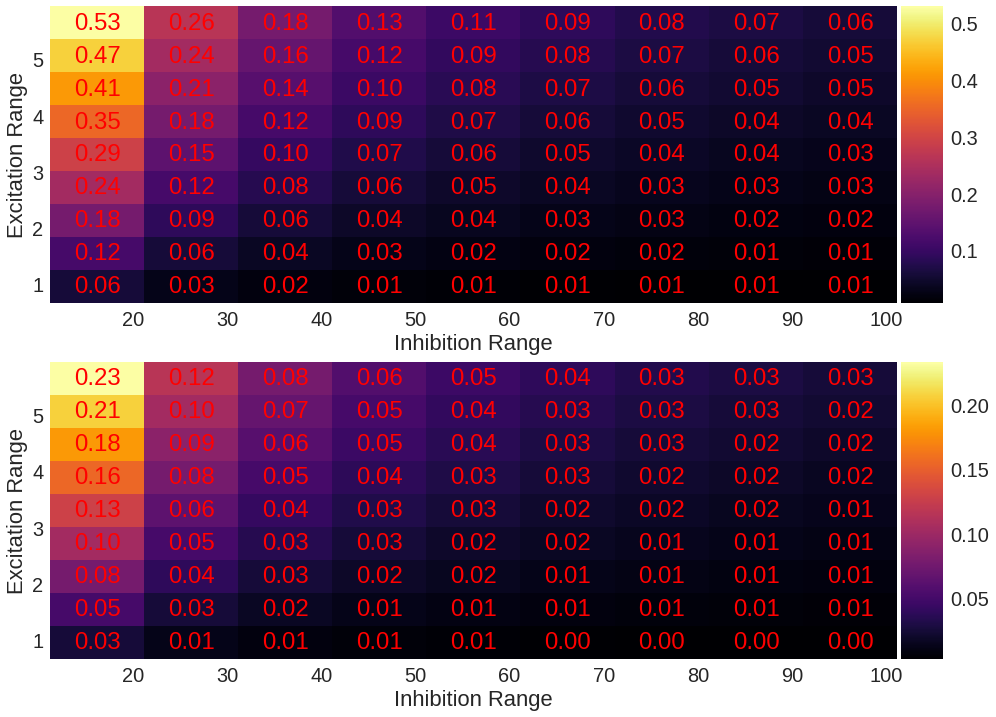

In [101]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

cmap = 'inferno'
text = True

extent = [inhibitions_real[0], inhibitions_real[-1], values_real[0], values_real[-1]]
im1 = ax1.imshow(ratio_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

im2 = ax2.imshow(ratio_matrix_ampa, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')

ax2.set_xlabel('Inhibition Range')
ax2.set_ylabel('Excitation Range')

ax2.grid()

# Add the text
x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibitions.size
size_y = values.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

if text:
    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label1 = ratio_matrix[y_index, x_index]
            label2 = ratio_matrix_ampa[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            label1 = "{:4.2f}".format(label1)
            label2 = "{:4.2f}".format(label2)
            ax1.text(text_x, text_y, label1, color='red', ha='center', va='center')
            ax2.text(text_x, text_y, label2, color='red', ha='center', va='center')


            
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');            

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical');     

In [59]:
hypercolumns = 4
minicolumns = 30
n_patterns = 10
sequences = [[i for i in range(n_patterns)]]

beta = False
value = 1
inhibition = -0.1
extension = 1
decay_factor = 0.3
sequence_decay = 0.0

values = np.arange(1, 55, 5)
inhibitions = np.arange(1, 55, 5)
ratio_matrix = np.zeros((values.size, inhibitions.size))
ratio_matrix_ampa =  np.zeros((values.size, inhibitions.size))

for value_index, value in enumerate(values):
    for inhibition_index, inhibition in enumerate(inhibitions):
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=-inhibition,
                                    extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratio_matrix[value_index, inhibition_index] = ratio
        
        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=True)
        ratio_matrix_ampa[value_index, inhibition_index] = ratio

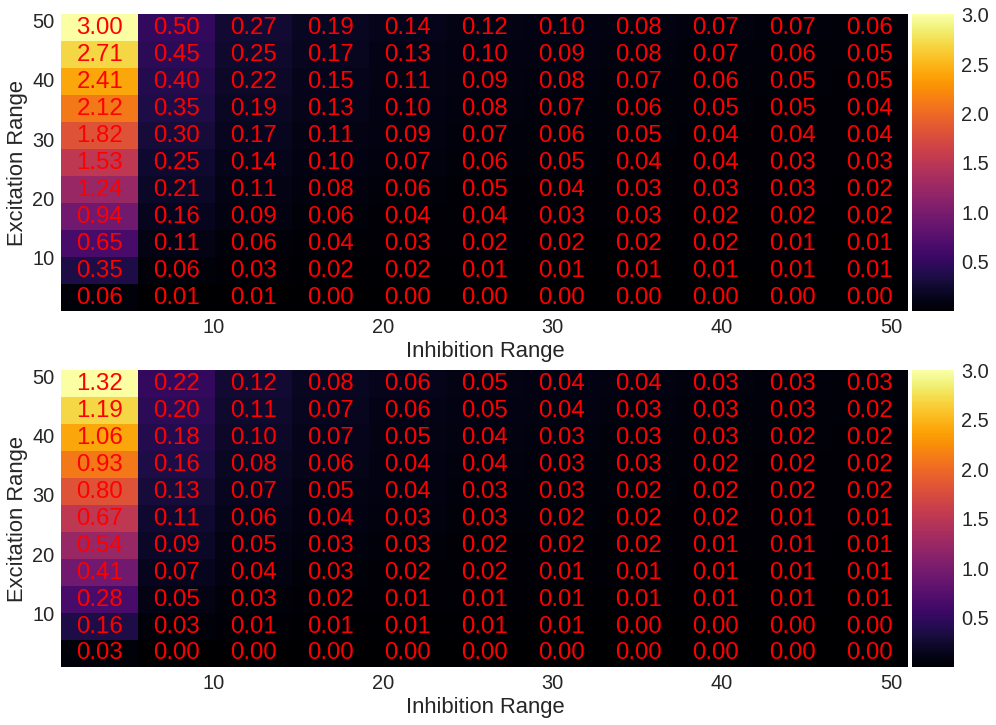

In [60]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

cmap = 'inferno'
text = True

extent = [inhibitions[0], inhibitions[-1], values[0], values[-1]]
im1 = ax1.imshow(ratio_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

im2 = ax2.imshow(ratio_matrix_ampa, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')

ax2.set_xlabel('Inhibition Range')
ax2.set_ylabel('Excitation Range')

ax2.grid()

# Add the text
x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibitions.size
size_y = values.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

if text:
    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label1 = ratio_matrix[y_index, x_index]
            label2 = ratio_matrix_ampa[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            label1 = "{:4.2f}".format(label1)
            label2 = "{:4.2f}".format(label2)
            ax1.text(text_x, text_y, label1, color='red', ha='center', va='center')
            ax2.text(text_x, text_y, label2, color='red', ha='center', va='center')


            
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');            

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax2, orientation='vertical');            

#### Let's calculate success recall for this values

#### Git machinery

In [18]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])